In [2]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time


In [3]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [4]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [5]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [6]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [7]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [8]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [9]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [10]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [11]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [12]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [38]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol=1e-03,full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [39]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


# Time and Error Comparion for N=2-4, M=2, B=1

In [40]:
#Parameter definition 
N_values = np.arange(2,6)
M=2
B = 0
A0 = 1
MgdResults = [] #gives ground state estimation at each iteration of gd
MgdState = []
MgdTime = []

MedState = []
MedTime = []

ActualEng = []
MengErr = []
MstateErr = []

In [55]:
#vary N value
for i in range(N_values.size):
    #gradient descent
    gradDescent = GradDescent(N_values[i], B, A0)
    gd = gradDescent(N_values[i], M)
    MgdResults.append(gd)
    MgdState.append(gd[0])
    MgdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N_values[i],B,A0)
    ed = groundState()
    MedState.append(ed[0])
    MedTime.append(ed[1])
    
    #Error
    gdEng = gd[0][2]
    edEng = ed[0][0]
    ActualEng.append(edEng)
    gdState = gd[0][1]
    edState = ed[0][1]
    errTemp = err(gdState,edState,gdEng,edEng)
    MengErr.append(errTemp[0])
    MstateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.956998
         Iterations: 19
         Function evaluations: 936
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: -1.280563
         Iterations: 40
         Function evaluations: 1944
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: -1.248810
         Iterations: 3
         Function evaluations: 300
         Gradient evaluations: 10


KeyboardInterrupt: 

In [ ]:
print('Gradient Descent Time: ', MgdTime)
print('Exact Diagonalization Time: ', MedTime)
print('Energy Error: ', MengErr)
print('Wavefunction Error: ', MstateErr)


In [ ]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("M = 2, B = 1",size =20)
ttl.set_position([.5, 0.92])
ax1 = plt.subplot(2,1,1)

color = 'tab:red'
ax1.set_xlabel('N Value')
ax1.set_ylabel('Wavefunction Error', color=color)
ax1.plot(N_values, MstateErr,color=color)
ax1.scatter(N_values, MstateErr,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Energy Error', color=color)  
ax2.plot(N_values, MengErr, color=color)
ax2.scatter(N_values, MengErr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = plt.subplot(2,1,2)

color = 'tab:red'
ax3.set_xlabel('N Value')
ax3.set_ylabel('Time (s)')
ax3.plot(N_values, MgdTime,color=color)
ax3.scatter(N_values, MgdTime,color=color, label = ' Gradient Descent')
color = 'tab:blue'
ax3.plot(N_values, MedTime, color=color)
ax3.scatter(N_values, MedTime, color=color, label = 'Exact Diagonalization')
ax3.legend()
plt.show()

Individual Error vs Iteration

In [ ]:
#N=2 groundstate error
N=2
parResults =MgdResults[N-2][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = MedState[N-2][1] 
gsEng = ActualEng[N-2]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    


plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 2, B = 1",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Wavefunction Error')
ax1.plot(iter, stateErr)

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy Error (Minimized by Gradient Descent)')
ax2.plot(iter, engErr)

In [ ]:
#N=3 groundstate error
N=3
parResults =MgdResults[N-2][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = MedState[N-2][1] 
gsEng = ActualEng[N-2]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 3, M = 2, B = 1",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Wavefunction Error')
ax1.plot(iter, stateErr)

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy Error (Minimized by Gradient Descent)')
ax2.plot(iter, engErr)


In [ ]:
#N=4 groundstate error
N=4
parResults =MgdResults[N-2][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = MedState[N-2][1] 
gsEng = ActualEng[N-2]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 4, M = 2, B = 1 ",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Wavefunction Error')
ax1.plot(iter, stateErr)

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy Error (Minimized by Gradient Descent)')
ax2.plot(iter, engErr)


In [ ]:
#N=5 groundstate error
N=5
parResults =MgdResults[N-2][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = MedState[N-2][1] 
gsEng = ActualEng[N-2]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 4, M = 2, B = 1 ",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Wavefunction Error')
ax1.plot(iter, stateErr)

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy Error (Minimized by Gradient Descent)')
ax2.plot(iter, engErr)


# Time and Error Comparion for N=2-4, M=3

In [33]:
#Parameter definition 
N_values = np.arange(2,6)
M=3
B = 1
A0 = 1
MgdResults = [] #gives ground state estimation at each iteration of gd
MgdState = []
MgdTime = []

MedState = []
MedTime = []

ActualEng = []
MengErr = []
MstateErr = []

In [34]:
#vary N value
for i in range(N_values.size):
    #gradient descent
    gradDescent = GradDescent(N_values[i], B, A0)
    gd = gradDescent(N_values[i], M)
    MgdResults.append(gd)
    MgdState.append(gd[0])
    MgdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N_values[i],B,A0)
    ed = groundState()
    MedState.append(ed[0])
    MedTime.append(ed[1])
    
    #Error
    gdEng = gd[0][2]
    edEng = ed[0][0]
    ActualEng.append(edEng)
    gdState = gd[0][1]
    edState = ed[0][1]
    errTemp = err(gdState,edState,gdEng,edEng)
    MengErr.append(errTemp[0])
    MstateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.749981
         Iterations: 7
         Function evaluations: 624
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -1.280691
         Iterations: 251
         Function evaluations: 17024
         Gradient evaluations: 532
Optimization terminated successfully.
         Current function value: -1.572849
         Iterations: 199
         Function evaluations: 18480
         Gradient evaluations: 462
Optimization terminated successfully.
         Current function value: -1.499916
         Iterations: 7
         Function evaluations: 1008
         Gradient evaluations: 21


In [35]:
print('Gradient Descent Time: ', MgdTime)
print('Exact Diagonalization Time: ', MedTime)
print('Energy Error: ', MengErr)
print('Wavefunction Error: ', MstateErr)

Gradient Descent Time:  [2.7984683513641357, 121.86490559577942, 289.01141238212585, 32.51083850860596]
Exact Diagonalization Time:  [0.0009963512420654297, 0.000997781753540039, 0.001001596450805664, 0.0009963512420654297]
Energy Error:  [0.20712612981260514, 8.49407868162011e-05, 2.670292626372195e-05, 0.3508647398587559]
Wavefunction Error:  [0.07612767510809026, 0.00012923493182803725, 5.183219054438748e-05, 0.056428758563417]


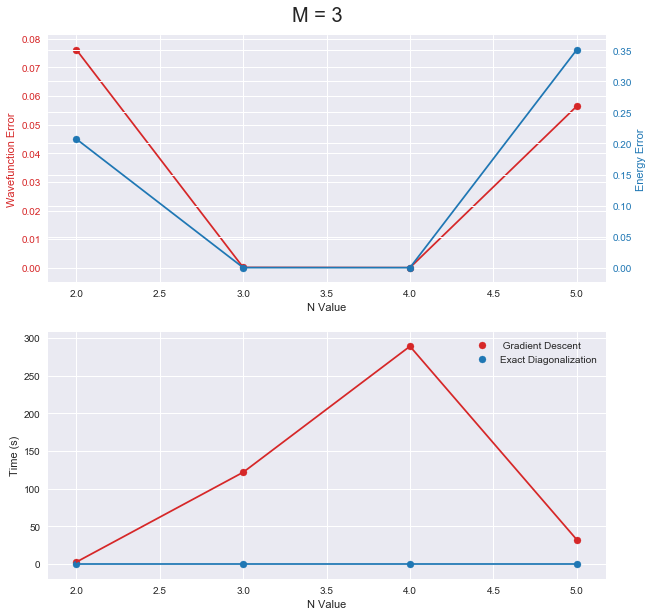

In [36]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("M = 3",size =20)
ttl.set_position([.5, 0.92])
ax1 = plt.subplot(2,1,1)

color = 'tab:red'
ax1.set_xlabel('N Value')
ax1.set_ylabel('Wavefunction Error', color=color)
ax1.plot(N_values, MstateErr,color=color)
ax1.scatter(N_values, MstateErr,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Energy Error', color=color)  
ax2.plot(N_values, MengErr, color=color)
ax2.scatter(N_values, MengErr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = plt.subplot(2,1,2)

color = 'tab:red'
ax3.set_xlabel('N Value')
ax3.set_ylabel('Time (s)')
ax3.plot(N_values, MgdTime,color=color)
ax3.scatter(N_values, MgdTime,color=color, label = ' Gradient Descent')
color = 'tab:blue'
ax3.plot(N_values, MedTime, color=color)
ax3.scatter(N_values, MedTime, color=color, label = 'Exact Diagonalization')
ax3.legend()
plt.show()

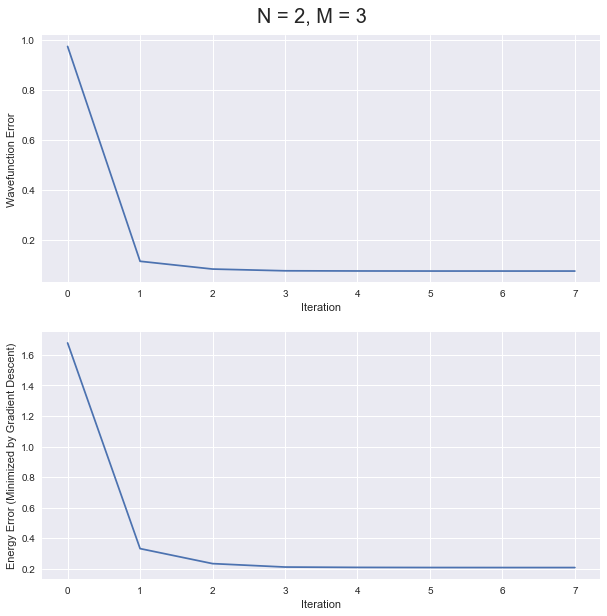

In [37]:
#N=2 groundstate error
N=2
parResults =MgdResults[N-2][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = MedState[N-2][1] 
gsEng = ActualEng[N-2]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    


plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 3",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Wavefunction Error')
ax1.plot(iter, stateErr)

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy Error (Minimized by Gradient Descent)')
ax2.plot(iter, engErr)

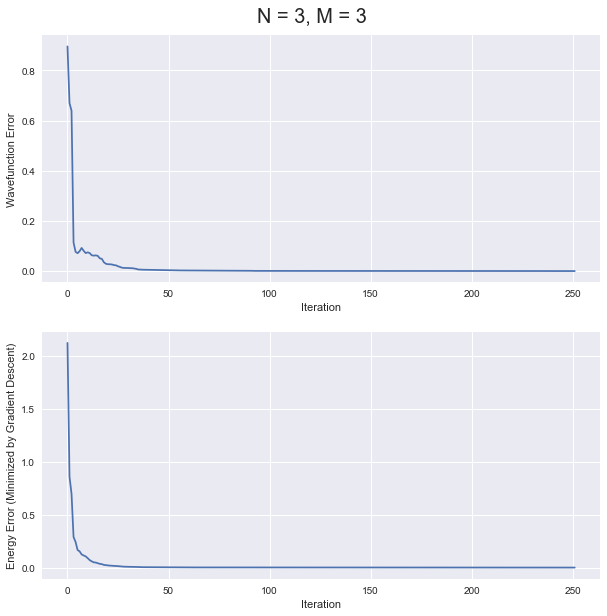

In [38]:
#N=3 groundstate error
N=3
parResults =MgdResults[N-2][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = MedState[N-2][1] 
gsEng = ActualEng[N-2]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 3, M = 3",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Wavefunction Error')
ax1.plot(iter, stateErr)

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy Error (Minimized by Gradient Descent)')
ax2.plot(iter, engErr)


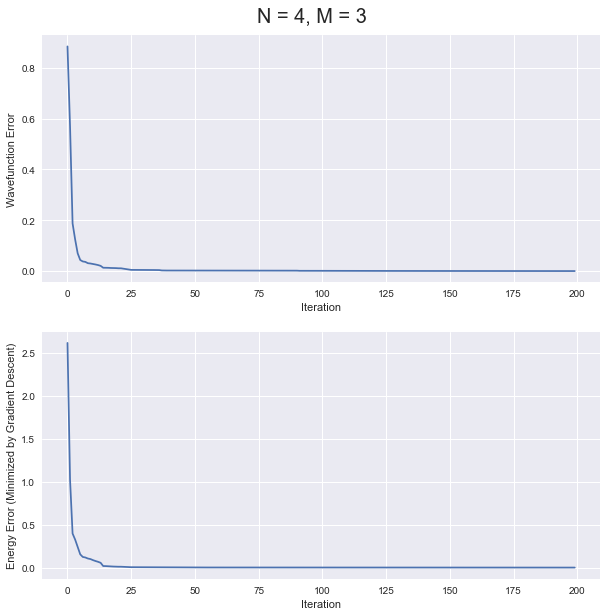

In [39]:
#N=4 groundstate error
N=4
parResults =MgdResults[N-2][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = MedState[N-2][1] 
gsEng = ActualEng[N-2]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 4, M = 3",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Wavefunction Error')
ax1.plot(iter, stateErr)

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy Error (Minimized by Gradient Descent)')
ax2.plot(iter, engErr)
